# 📘 CoEDiT Protocol: From Budget Entries to Commitment Networks

(Created 2025-06-25 Wed)

## Introduction

This notebook implements the CoEDiT (Commitment-Driven Enterprise Digital Twin) method as an end-to-end protocol. It transforms tabular budget entries—originally designed for regulatory compliance—into a machine-interpretable network of institutional commitments. By combining ontology-driven conceptual modeling, semantic web technologies, and heuristic inference, CoEDiT renders organizational structures intelligible as dynamic coordination networks. This protocol operationalizes the dialectical modeling loop (Conceptual Modeling → Data Mining → Reflexive Sensemaking → Conceptual Refinement) in a reproducible, Python-native workflow.


**Assumptions:**

* **Input 1:** A CSV file containing budget entries, with columns such as `Service`, `OrganizationalUnit`, `CostType`, and `AmountEUR`. This file provides the transactional substrate for modeling.
* **Input 2:** An RDF/Turtle file encoding the controlled vocabularies for categorical attributes, such as services, organizational units, and cost types. This supports semantic alignment.
* **Output:** An RDF knowledge graph representing inferred institutional commitments, serialized as semantic triples suitable for querying, reasoning, and visualization.


## Load and Inspect the Budget Dataset

In [1]:
# Import dependencies
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF
import pandas as pd

# Load budget entries from a CSV file into a DataFrame
bYYe = pd.read_csv("Input_bYYe.csv", sep=",", encoding="utf-8", index_col=0)
# Display dataset shape and sample entries for inspection
print(f"Input_bYYe.csv has shape: {bYYe.shape}")
print(bYYe.head(3).T.to_latex(index=True))

Input_bYYe.csv has shape: (125, 7)
\begin{tabular}{llll}
\toprule
Index & bYYe001 & bYYe002 & bYYe003 \\
\midrule
Service & 201 Air Traffic Management & 201 Air Traffic Management & 201 Air Traffic Management \\
OrganizationalUnit & 1000 Corporate Services & 1000 Corporate Services & 1000 Corporate Services \\
CostType & a Staff Costs & b Operating Costs & c Depreciation Costs \\
AmountEUR & 8752200 & 624800 & 18485100 \\
AmountEnRouteEUR & 6867900 & 585300 & 15084600 \\
AmountTerminalEUR & 1884300 & 39500 & 3400500 \\
AccountingPeriod & YYYY & YYYY & YYYY \\
\bottomrule
\end{tabular}



In [2]:
# Identify unique categorical values per attribute (semantic diversity)
bYYe.nunique()

Service                10
OrganizationalUnit     18
CostType                3
AmountEUR             124
AmountEnRouteEUR      122
AmountTerminalEUR     101
AccountingPeriod        1
dtype: int64

## Infer Top Contributors

In [3]:
# Heuristic assumption: the OrganizationalUnit with the highest financial contribution 
# per Service is its provisional proxy agent
topContributors = bYYe.groupby("Service")["AmountEUR"].idxmax()
topContributors = bYYe.loc[topContributors, ["Service", "OrganizationalUnit"]]
topContributors = topContributors.set_index("Service").to_dict()["OrganizationalUnit"]

# Assign inferred commitments (deliversTo) based on proxy agency
bYYe['deliversTo'] = bYYe['Service'].map(topContributors)

# Print inferred commitment relations as semantic triples
for k,v in topContributors.items():
    print(f"<{k}> hasTopContributor <{v}>")


<201 Air Traffic Management> hasTopContributor <2111 Area Control Centre (ACC)>
<202 Communication> hasTopContributor <2212 Aeronautical Telecommunications Services>
<203 Navigation> hasTopContributor <2213 Navigation and Radio Communication Services>
<204 Surveillance> hasTopContributor <2211 Surveillance and Radar Services>
<205 Search and rescue> hasTopContributor <2112 Rescue Coordination Centre (RCC)>
<206 Aeronautical information> hasTopContributor <2410 ATM Information Management>
<207 Meteorological services> hasTopContributor <1000 Corporate Services>
<208 Supervision costs> hasTopContributor <2310 ATM/ANS Methodology and Standards>
<209 Other State costs> hasTopContributor <4210 Financial Management and Accounting>
<299 Indirect costs> hasTopContributor <1000 Corporate Services>


## Clean Top Consumers

In [4]:
# Extract top financial contributors per OrganizationalUnit, infer deliversTo relations
topConsumers = (
    bYYe.sort_values("AmountEUR", ascending=False)
        .groupby("OrganizationalUnit")
        .head(3)
        .loc[:, ["OrganizationalUnit", "deliversTo"]]
        .reset_index(drop=True)
)
print(f"Shape of infered dataset :{topConsumers.shape}")

# Eliminate reflexive or redundant relations
topConsumers = topConsumers.drop_duplicates(subset=["OrganizationalUnit", "deliversTo"])
topConsumers = topConsumers[topConsumers["OrganizationalUnit"] != topConsumers["deliversTo"]].reset_index(drop=True)
print(f"Shape after cleaning : {topConsumers.shape}")

# Manually augment network with additional commitments (Chargable Services)
new_rows = pd.DataFrame([
    {
        "OrganizationalUnit": bYYe.loc[bYYe["AmountEnRouteEUR"].idxmax()]["OrganizationalUnit"],
        "deliversTo": "En Route Operations"
    },
    {
        "OrganizationalUnit": bYYe.loc[bYYe["AmountTerminalEUR"].idxmax()]["OrganizationalUnit"],
        "deliversTo": "Terminal Operations"
    },
    {
        "OrganizationalUnit": "2130 Regional Airport ATM Services",
        "deliversTo": "Terminal Operations"
    }
])
print("Another 3 rows added to topConsumers:")
topConsumers = pd.concat([topConsumers, new_rows], ignore_index=True)
topConsumers

Shape of infered dataset :(50, 2)
Shape after cleaning : (25, 2)
Another 3 rows added to topConsumers:


,OrganizationalUnit,deliversTo
0,2120 Approach and Aerodrome Control Centre,2111 Area Control Centre (ACC)
1,1000 Corporate Services,2111 Area Control Centre (ACC)
2,7000 ATM Training Academy,1000 Corporate Services
3,2130 Regional Airport ATM Services,2111 Area Control Centre (ACC)
4,4610 Asset and Facility Management,2111 Area Control Centre (ACC)
5,2000 Air Navigation Operations Management,1000 Corporate Services
6,2310 ATM/ANS Methodology and Standards,2111 Area Control Centre (ACC)
7,2320 Project Management Office (PMO),1000 Corporate Services
8,4210 Financial Management and Accounting,1000 Corporate Services
9,2211 Surveillance and Radar Services,2111 Area Control Centre (ACC)


## RDF Serialization

In [5]:
# Construct RDF graph for inferred commitment structures
voc = Graph()
voc.parse("Input_bYYe_Vocabulary.ttl", format="turtle")
print("Input_bYYe_Vocabulary has %s statements." % len(voc))

# Bind semantic namespaces for alignment and reasoning
g = Graph()
schema = Namespace("http://schema.org/")
g.namespace_manager.store.bind("schema", schema, override=True)  # Ensures "schema" is used correctly
skos = Namespace("http://www.w3.org/2004/02/skos/core#")
g.bind("skos", skos)
ses = Namespace("https://eur-lex.europa.eu/eli/reg/2024/2803/oj/")
g.bind("ses", ses)
pecha = Namespace("http://data.europa.eu/eli/reg_impl/2019/317#")
g.bind("pecha", pecha)
pechar = Namespace("https://lustraka.github.io/resources/pechar/")
g.bind("pechar", pechar)
gufo = Namespace("http://purl.org/nemo/gufo#")
g.bind("gufo", gufo)

# Helper to lookup URI by label
def get_uri_by_label(label):
    for s in voc.subjects(predicate=schema.name, object=Literal(label)):
        return s
    return None

# Map DataFrame entries to RDF triples, anchoring categorical attributes to controlled vocabulary
for index, row in bYYe.iterrows():
    entry_uri = URIRef(f"https://lustraka.github.io/resources/pechar/{index}")
    g.add((entry_uri, RDF.type, pechar.BudgetEntry))
    g.add((entry_uri, RDF.type, gufo.IntrinsicAspect))

    for col in bYYe.columns:
        if col == "deliversTo":
            continue
        predicate = URIRef(f"https://lustraka.github.io/resources/pechar/{col}")

        # Special case: replace literal service label with URI from voc
        if col in ["Service", "OrganizationalUnit", "CostType"]:
            term_uri = get_uri_by_label(row[col])
            if term_uri:
                g.add((entry_uri, predicate, term_uri))
            else:
                # Fallback to literal if no URI found
                g.add((entry_uri, predicate, Literal(row[col])))
        else:
            g.add((entry_uri, predicate, Literal(row[col])))

print("Encoded dataset has %s statements." % len(g))

# Merge vocabulary graph with the budget entries graph
for s, p, o in voc:
    g.add((s, p, o))

print("Combined graph has %s statements." % len(g))

Input_bYYe_Vocabulary has 247 statements.
Encoded dataset has 1125 statements.
Combined graph has 1372 statements.


## Add Inferred Relations

In [6]:
# # Add inferred institutional relations to graph
for service, ou in topContributors.items():
    service_uri = get_uri_by_label(service)
    ou_uri = get_uri_by_label(ou)
    if service_uri and ou_uri:
        g.add((service_uri, pechar.hasTopContributor, ou_uri))

for index, row in topConsumers.iterrows():
    ou_uri = get_uri_by_label(row["OrganizationalUnit"])
    service_uri = get_uri_by_label(row["deliversTo"])
    if ou_uri and service_uri:
        g.add((ou_uri, pechar.deliversTo, service_uri))

print("Final graph has %s statements." % len(g))

# Serialize the graph to a TTL file
g.serialize(destination="Output_bYYe.ttl", format="turtle")

Final graph has 1410 statements.


<Graph identifier=Nfcb24709a4b746cb972bae8457141d3c (<class 'rdflib.graph.Graph'>)>

## Visualization

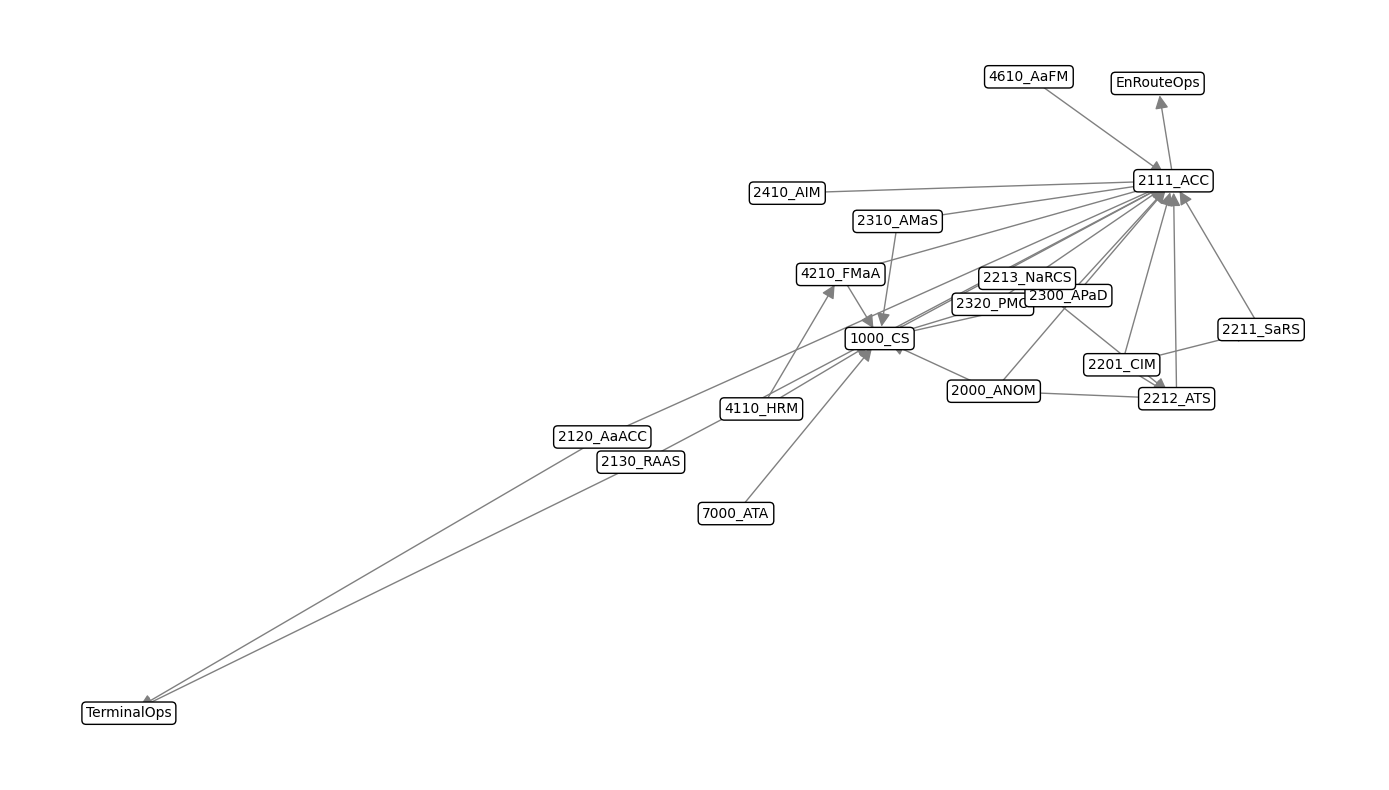

In [7]:
# Visualize commitment network as directed graph using NetworkX and PyDot
# %pip install scipy
import networkx as nx
import matplotlib.pyplot as plt

# Build graph
G = nx.DiGraph()
for s, p, o in g.triples((None, pechar.deliversTo, None)):
    G.add_edge(str(s), str(o))

# Layout
pos = nx.spring_layout(G, k=0.5, seed=42)
#pos = nx.kamada_kawai_layout(G)

# Strip namespace
def strip_namespace(uri):
    return uri.split('/')[-1]

# Labels
labels = {node: strip_namespace(node) for node in G.nodes}

# Draw edges with arrowheads
plt.figure(figsize=(14, 8))
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray')

# Draw nodes as rectangles (boxes)
for node in G.nodes:
    x, y = pos[node]
    plt.text(
        x, y, labels[node],
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=10
    )

plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
# Export graph in DOT, PNG, and PDF formats
def strip_namespace(uri):
    return uri.split("/")[-1]
G_cleaned = nx.DiGraph()
for s, o in G.edges():
    G_cleaned.add_edge(strip_namespace(s), strip_namespace(o))
nx.drawing.nx_pydot.write_dot(G_cleaned, "PoEM_bYYe_deliversTo.dot")
import pydot
# Read the DOT file
(graph,) = pydot.graph_from_dot_file("PoEM_bYYe_deliversTo.dot")
# Set the layout direction: Left to Right
graph.set_rankdir("LR")
# Save the graph to a PNG file
graph.write_png("PoEM_bYYe_deliversTo.png")
# Save the graph to a PDF file
graph.write_pdf("PoEM_bYYe_deliversTo.pdf")
print("DOT exported to PoEM_bYYe_deliversTo.dot, PNG, and PDF.")

DOT exported to PoEM_bYYe_deliversTo.dot, PNG, and PDF.
